In this experiment, we use previous solutions for sparsity enhacement.

# Primal Dual to solve Discrete Optimal Transport

<div class="alert alert-block alert-success">
    
This notebook we aim at solving DOT instances using modern optimisation algorithms that outperform the simplex method. To do this we will use the Primal Dual framework. 
    
The notebook is divided in three parts. First, Condat's projection into the ℓ<sub>1</sub> ball algorithm is implemented. Second, the algorithm is used to find feasible solutions of DOT. Finally, the Primal Dual algorithm is tested. The results are automatically stored with an unique identifier and some performance plots are presented.
</div>

* Laurent Condat. <i>Fast projection onto the simplex and the ℓ<sub>1</sub> ball</i>. Math. Program. 158, 575–585 (2016). [https://doi.org/10.1007/s10107-015-0946-6](https://doi.org/10.1007/s10107-015-0946-6). _Also available at_ [https://hal.archives-ouvertes.fr/hal-01056171v2](https://hal.archives-ouvertes.fr/hal-01056171v2).



* V ̃u, B. (2011). <i>A splitting algorithm for dual monotone inclusions involving cocoercive operators </i>. Adv. Comput. Math, pages 667–681. [https://doi.org/10.1007/s10444-011-9254-8](https://doi.org/10.1007/s10444-011-9254-8).


* Emmanuel J. Candès, Michael B. Wakin, Stephen P. Boyd ()
Enhancing Sparsity by Reweighted $\ell_1$ Minimization

<div class="alert alert-block alert-info">
Packages
</div>

In [1]:
import numpy    as np
import numpy.ma as ma
import pandas   as pd
import time
import os
import matplotlib.pyplot as plt

# Particular functions
from numpy import zeros, zeros_like, allclose, where, ones, inf, absolute, linspace, tile, maximum, minimum
from numpy.random import default_rng as rng
from numba import jit
from scipy.spatial.distance import cdist
from scipy.linalg import norm

# Algorithm

Now, we will run the Primal Dual algorithm addapted for DOT. To test it, we will run it against some of the DOTMark files. We will aim to transport from one given image to another, which are normalised and flattened in ```C```-order. The matrix of costs is based on a uniform grid within $[0,1]^2$ with $M$ points for the source and $N$ points for the target.

## Instance information

In [2]:
folder = 'Microscopy_Sized'
path = 'Exact/' + folder + '/'

In [3]:
files = [f[:-9] for f in os.listdir(path) if f.endswith('.txt')]
print('There are', len(files), 'instances in this location:')
display(files)

There are 4 instances in this location:


['data16_1002-data16_1010_p=S2',
 'data8_1002-data8_1010_p=S2',
 'data32_1002-data32_1010_p=S2',
 'data64_1002-data64_1010_p=S2']

Select one instance:

In [4]:
instance = files[2]
full_path = path + instance

Load data:

In [5]:
m = np.load(full_path + '_m.npy');    M = m.size
n = np.load(full_path + '_n.npy');    N = n.size
c = np.load(full_path + '_Cost.npy')
sol = np.load(full_path + '_Sol.npy')

In [6]:
with open(full_path + '_Time.txt', 'r') as f:
    obj_exact = eval((f.readlines())[0])['Obj']

Load ER solution:

In [7]:
ER_location = folder + '_Results' + '/' + instance + '/'

In [8]:
ER = np.load( ER_location + 'ER-' + '_Sol.npy')

## Run algorithm

<div class="alert alert-block alert-warning">
    
In what follows, we provide tests for the chosen instance running the Primal Dual approach given by Bằng Công Vũ (2011).
    
    
* V ̃u, B. (2011). <i>A splitting algorithm for dual monotone inclusions involving cocoercive operators </i>. Adv. Comput. Math, pages 667–681. [https://doi.org/10.1007/s10444-011-9254-8](https://doi.org/10.1007/s10444-011-9254-8).
</div>

In [9]:
def primal_dual_improved(c,m,n,iters, collect_obj = False, true_obj = None, 
                         true_obj_tol = 1e-4, true_solution = None, save_iter = False, 
                         guess_x = None,  guess_y = None,
                         τ = 1e-3 * 1.9):
    # Algorithm for calculating solution x, in the primal space
    # and y_1, y_2 in the dual space.
    # Also returns the value of the objective function c*x at each
    # iteration.
    
    '''
        Initialise parameters
    '''
    # Initialise τ
    #τ = 1e-3 * 1.9
    
    # Initialise σ
    σ = 1.0/τ - 1e-5
    
    # Initialise ρ
    ρ = 1.9 #- 1e-4 # this helped in 8x8 but not for bigger colour instances
    
    # Fetch lengths of m and n.
    N = n.size
    M = m.size
    
    print('\n*** Primal Dual with M = {}, N = {}, MN = {} ***\n\n'.format(M,N,M*N))
    
    
    '''
        Initialise matrices
    '''
    # Initialise x & y
    #Initialise x & y
    if guess_x is not None:
        x = guess_x.copy()
    if guess_y is not None:
        y = guess_y.copy()
    else:
        x, y = zeros((2,M,N));            #y[0,:] = n;    y[:,0] = m
    #Initialise xₖ, yₖ, xₚ, u, κ
    xₖ, yₖ, xₚ, u = zeros((4,M,N))
    κ_1, κ_2 = zeros(M), zeros(N)

    '''
        Information from true solution (if available)
    '''
    # Store current objective value
    if collect_obj == True:
        obj = [ (c*x).sum() ]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (c*sol).sum()
        print('Objective from ground truth:', obj_exact,'\n')
        
    '''
        Iterate the Primal Dual scheme
    '''
    
    every_iter = {
        'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'rel_var':[], 'l_1':[],
        'hyperₘ':{'L2': [], 'max': [], 'min':[]}, 'hyperₙ':{'L2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'l_1':[]}
    
    if true_solution is not None:
        print('     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  ')
        print( '{:-^66}'.format('') )
        
    timed = 0.0
    
    for k in range(iters):
        #print(xₘ.size)
        it_time = time.time()
        
        
        xₖ = x - τ * (c + y)
        maximum(xₖ, 0.0, xₖ)             # xₖ = where(xₖ < 0.0, 0.0, xₖ)
        
        u = y/σ + 2.0*xₖ - x        # u = (y + σ * (2.0 * xₖ - x))/σ
        
        κ_1 = u.sum(1) - m
        κ_2 = u.sum(0) - n
        
        β_1 = κ_1.sum() / (M + N)
        β_2 = κ_2.sum() / (M + N)
               
        yₖ = σ*(tile( (κ_1 - β_1)/N, (N,1)).T + tile( (κ_2 - β_2)/M, (M,1)))
        
    
        # Reset x and y for the next iteration
        x *= 1-ρ;   xₖ *= ρ;     x += xₖ
        y *= 1-ρ;   yₖ *= ρ;     y += yₖ
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        # Recover values from mask
        ℓ_1 = norm(x.ravel(),1)
        
        # Update objective function
        if collect_obj == True:
            obj.append( (c*x).sum() )
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
        
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
            r, s   = x.sum(1) - m, x.sum(0) - n
            
            every_iter['it'].append( k )
            every_iter['obj'].append( (c*x).sum() )
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( timed )
            every_iter['dist_x'].append( frob_d )
            every_iter['rel_var'].append( norm(xₚ-x, 'fro')/norm(x, 'fro') if not allclose(x,0) else np.nan )
            every_iter['l_1'].append(ℓ_1)
            # Constrained satisfactibility
            every_iter['hyperₘ']['L2'].append( norm(r)/norm(m) )
            every_iter['hyperₘ']['max'].append( abs(r/maximum(m,1e-7)).max() )
            every_iter['hyperₘ']['min'].append( abs(r/maximum(m,1e-7)).min() )
            every_iter['hyperₙ']['L2'].append( norm(s)/norm(n) )
            every_iter['hyperₙ']['max'].append( abs(s/maximum(n,1e-7)).max() )
            every_iter['hyperₙ']['min'].append( abs(s/maximum(n,1e-7)).min() )
            
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if dist_true_sol < true_obj_crit:
                frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
                
                every_critical['it'].append( k )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( timed )
                every_critical['dist_x'].append( frob_d )
                every_critical['l_1'].append(ℓ_1)
                
                print('* {0:6.0f} |   {1:.1e} |  {2:1.1e}  | {3:8.2f} s |   {4:4.4f} |  {5:4.4f}'.format(k,
                                                                            true_obj_crit,
                                                                            dist_true_sol,
                                                                            timed,frob_d,ℓ_1))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                true_obj_crit *= 0.1
        
        # Update previous step
        xₚ = x.copy()
                
    if true_solution is not None:
        print( '{:-^66}'.format('') )
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    
    if collect_obj == False and save_iter == True:
        return x, y, every_iter
    if collect_obj == True and save_iter == True:
        return x, y, obj, every_critical, every_iter
    else:
        return x

### Results of $8\times 8$

Sparsity plots:

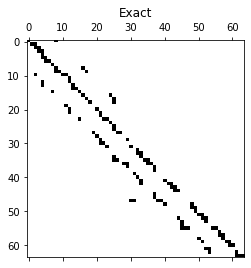

In [10]:
plt.spy(sol); plt.title('Exact'); plt.show()

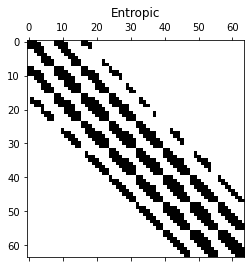

In [11]:
plt.spy(ER); plt.title('Entropic'); plt.show()

**Initial run:**

In [12]:
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 2000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      4 |   1.0e+00 |  5.6e-01  |     0.00 s |   0.8888 |  1.1784
*      6 |   1.0e-01 |  5.9e-02  |     0.00 s |   0.8619 |  1.0856
*    327 |   1.0e-02 |  9.8e-03  |     0.03 s |   0.3478 |  0.9997
*    445 |   1.0e-03 |  9.1e-04  |     0.04 s |   0.3268 |  1.0005
*    723 |   1.0e-04 |  6.3e-05  |     0.05 s |   0.3111 |  0.9999
*    724 |   1.0e-05 |  4.7e-06  |     0.05 s |   0.3111 |  0.9999
*   1203 |   1.0e-06 |  6.7e-07  |     0.09 s |   0.3110 |  1.0000
*   1241 |   1.0e-07 |  2.6e-08  |     0.09 s |   0.3110 |  1.0001
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 0.0888 seconds and 1241 iterations


In [13]:
every_iter['hyperₘ']['max'][-1], every_iter['hyperₙ']['max'][-1], (c*x).sum()

(0.00555526991049769, 0.00345889403902181, 0.016271821018138663)

In [14]:
# Support measures
x_mask = (x<=0)
Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x_mask] = 0;    Masking_Truth[sol<=0] = 0
Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
    Masking_sol.sum(),x_mask.sum(),sol[sol>0].size) )

Shared support:   127 
Approximation:    2846 
Exact support:    127 


Now let's modify $c$:

In [15]:
xₐ = x.copy()
yₐ = y.copy()

In [16]:
w  = 1/( abs(c*xₐ) + 0.1 )

In [17]:
x, y, obj, every_critical, every_iter = primal_dual_improved(c*w,m,n, 2000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_x = xₐ, guess_y = yₐ)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
------------------------------------------------------------------

Algorithm stopped after 0.1314 seconds and 1999 iterations


In [18]:
# Support measures
x_mask = (x<=0)
Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x_mask] = 0;    Masking_Truth[sol<=0] = 0
Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
    Masking_sol.sum(),x_mask.sum(),sol[sol>0].size) )

Shared support:   126 
Approximation:    2863 
Exact support:    127 


In [19]:
every_iter['hyperₘ']['max'][-1], every_iter['hyperₙ']['max'][-1], (c*x).sum()

(0.0018425052456293375, 0.005335722955798731, 0.016270028606934217)

Let us do it again:

In [20]:
x_b = x.copy()
y_b = y.copy()
w  = 1/( abs(c*x_b) + 0.1 )

In [30]:
x, y, obj, every_critical, every_iter = primal_dual_improved(c*w,m,n, 2000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_x = x_b, guess_y = y_b)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
------------------------------------------------------------------

Algorithm stopped after 0.1390 seconds and 1999 iterations


In [31]:
# Support measures
x_mask = (x<=0)
Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x_mask] = 0;    Masking_Truth[sol<=0] = 0
Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
    Masking_sol.sum(),x_mask.sum(),sol[sol>0].size) )

Shared support:   124 
Approximation:    2867 
Exact support:    127 


In [32]:
every_iter['hyperₘ']['max'][-1], every_iter['hyperₙ']['max'][-1], (c*x).sum()

(0.00017338679163741546, 0.0004472124942751807, 0.016271794572751845)

Once more...

In [33]:
x_c = x.copy()
y_c = y.copy()
w  = 1/( abs(c*x_c) + 0.1 )

In [34]:
x, y, obj, every_critical, every_iter = primal_dual_improved(c*w,m,n, 2000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_x = x_c, guess_y = y_c)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
------------------------------------------------------------------

Algorithm stopped after 0.1353 seconds and 1999 iterations


In [35]:
# Support measures
x_mask = (x<=0)
Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x_mask] = 0;    Masking_Truth[sol<=0] = 0
Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
    Masking_sol.sum(),x_mask.sum(),sol[sol>0].size) )

Shared support:   123 
Approximation:    2873 
Exact support:    127 


In [36]:
every_iter['hyperₘ']['max'][-1], every_iter['hyperₙ']['max'][-1], (c*x).sum()

(8.824337756717268e-05, 0.00010116360738312658, 0.016271927881203806)

We observe a reduction in the maximum error for constraint satisfactibility. 

Let us use a loop now:

In [39]:
for i in range(20):
    x_prev = x.copy()
    y_prev = y.copy()
    w  = 1/( abs(c*x_prev) + 0.1 )
    
    x, y, obj, every_critical, every_iter = primal_dual_improved(c*w,m,n, 2000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_x = x_prev, guess_y = y_prev)
    
    # Support measures
    x_mask = (x<=0)
    Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x_mask] = 0;    Masking_Truth[sol<=0] = 0
    Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
    print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
        Masking_sol.sum(),x_mask.sum(),sol[sol>0].size) )

    # Constraint satisfactibility
    print(every_iter['hyperₘ']['max'][-1], every_iter['hyperₙ']['max'][-1], (c*x).sum())


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
------------------------------------------------------------------

Algorithm stopped after 0.1363 seconds and 1999 iterations
Shared support:   116 
Approximation:    2896 
Exact support:    127 
5.8709109925884025e-05 4.428801815770359e-05 0.01627213364736112

*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
------------------------------------------------------------------

Algorithm stopped after 0.1314 seconds and 1999 iterations
Shared support:   116 
Approximation:    2896 
Exact support:    127 
6.077619478010069e-05 3.240798936502445e-05 0.0162718588299

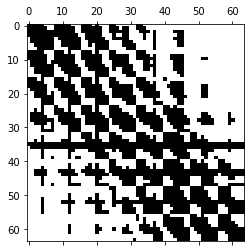

In [41]:
plt.spy(x); plt.show()

The current solution seems to be of better quality, as it satisfies the constraints with additional numerical precision while not acting like a "false" minimum:

In [50]:
(c*(x - sol)).sum(), (c*(xₐ - sol)).sum()

(3.3458148139845975e-08, -4.307017047020965e-10)

**Include initial mask from ER:**

In [81]:
x = ER.copy()
y = np.zeros(ER.shape)
w  = 1/( abs(c*x) + 0.1 )

In [82]:
for i in range(20):
    w[ER>0] = 1/(np.maximum(x[ER>0],ER[ER>0]) + 0.1)
    
    x, y, obj, every_critical, every_iter = primal_dual_improved(w*c,m,n, 10000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_x = x, guess_y = y)
    
    # Support measures
    x_mask = (x<=0)
    Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x_mask] = 0;    Masking_Truth[sol<=0] = 0
    Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
    print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
        Masking_sol.sum(),x_mask.sum(),sol[sol>0].size) )

    # Constraint satisfactibility
    print(every_iter['hyperₘ']['max'][-1], every_iter['hyperₙ']['max'][-1], (c*x).sum())


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
------------------------------------------------------------------

Algorithm stopped after 0.6274 seconds and 9999 iterations
Shared support:   117 
Approximation:    3344 
Exact support:    127 
0.0011258881387186095 0.0005505882534156013 0.01627301798420148

*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
------------------------------------------------------------------

Algorithm stopped after 0.6283 seconds and 9999 iterations
Shared support:   121 
Approximation:    3337 
Exact support:    127 
0.0006789898681742059 0.000706367938937873 0.01627485618899


------------------------------------------------------------------

Algorithm stopped after 0.6223 seconds and 9999 iterations
Shared support:   121 
Approximation:    3334 
Exact support:    127 
0.00010173300262628318 4.224356725759424e-05 0.016271698589796983

*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
------------------------------------------------------------------

Algorithm stopped after 0.6231 seconds and 9999 iterations
Shared support:   121 
Approximation:    3334 
Exact support:    127 
0.00010516268072643649 4.742227876641746e-05 0.016271485019547956

*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
-----------------------------------------------------------

In [87]:
(c*x).sum() - obj_exact

1.6602358673262207e-07

### Results for $32\times 32$

Sparsity plots:

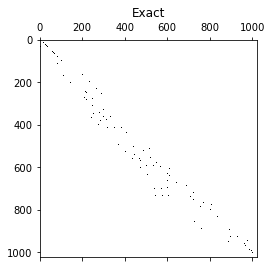

In [10]:
plt.spy(sol); plt.title('Exact'); plt.show()

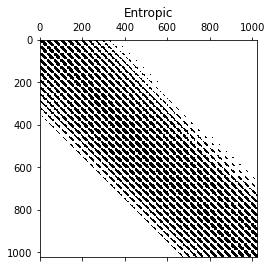

In [11]:
plt.spy(ER); plt.title('Entropic'); plt.show()

**Run without a guess:**

In [18]:
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 10000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-4, true_solution = sol, save_iter = True)


*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      1 |   1.0e+00 |  1.0e+00  |     0.05 s |   0.9982 |  0.0172
*    759 |   1.0e-01 |  1.0e-01  |    15.15 s |   0.6419 |  1.0023
*   1249 |   1.0e-02 |  9.9e-03  |    25.03 s |   0.4339 |  1.0010
*   1341 |   1.0e-03 |  9.4e-04  |    26.88 s |   0.4200 |  1.0001
*   1353 |   1.0e-04 |  5.6e-05  |    27.13 s |   0.4188 |  0.9996
*   3689 |   1.0e-05 |  4.8e-06  |    74.55 s |   0.3876 |  1.0001
*   4528 |   1.0e-06 |  3.5e-07  |    91.65 s |   0.3874 |  1.0001
*   4852 |   1.0e-07 |  4.3e-08  |    98.26 s |   0.3874 |  0.9999
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 98.2627 seconds and 4852 iterations


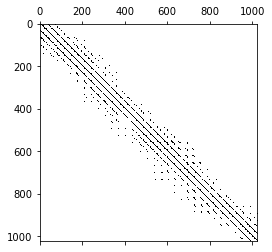

In [19]:
xₐ = x.copy()
plt.spy(x); plt.show()

In [20]:
every_iter['hyperₘ']['max'][-1], every_iter['hyperₙ']['max'][-1], (c*x).sum()

(0.18002737373353822, 0.11604564937670546, 0.010675024508522967)

In [14]:
for i in range(20):
    x_prev = x.copy()
    y_prev = y.copy()
    w  = 1/( abs(c*x_prev) + 0.1 )
    
    x, y, obj, every_critical, every_iter = primal_dual_improved(c*w,m,n, 1000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-3, true_solution = sol, save_iter = True, guess_x = x_prev, guess_y = y_prev)
    
    # Support measures
    x_mask = (x<=0)
    Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x_mask] = 0;    Masking_Truth[sol<=0] = 0
    Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
    print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
        Masking_sol.sum(),x_mask.sum(),sol[sol>0].size) )

    # Constraint satisfactibility
    print(every_iter['hyperₘ']['max'][-1], every_iter['hyperₙ']['max'][-1], (c*x).sum())


*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      5 |   1.0e+00 |  9.7e-01  |     0.13 s |   0.8220 |  0.3048
*     13 |   1.0e-01 |  9.1e-02  |     0.27 s |   0.9388 |  0.4721
*     61 |   1.0e-02 |  7.5e-03  |     1.28 s |   1.3588 |  1.1910
------------------------------------------------------------------

Algorithm stopped after 20.7904 seconds and 999 iterations
Shared support:   1634 
Approximation:    1034223 
Exact support:    2047 
1.7395248697068486 2.4765114263663133 0.005320463682204577

*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
------------------------------------------

------------------------------------------------------------------

Algorithm stopped after 20.2959 seconds and 999 iterations
Shared support:   2007 
Approximation:    1034680 
Exact support:    2047 
0.07137390473145494 0.08037588940970063 0.010588382967172662

*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
------------------------------------------------------------------

Algorithm stopped after 19.9975 seconds and 999 iterations
Shared support:   2009 
Approximation:    1034659 
Exact support:    2047 
0.060023959775238486 0.08465297717382991 0.010601985762233404

*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
--------------------------------------------

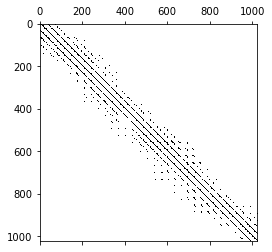

In [15]:
plt.spy(x); plt.show()

In [16]:
every_iter['hyperₘ']['max'][-1], every_iter['hyperₙ']['max'][-1], (c*x).sum()

(0.07079668544858828, 0.058196512398686964, 0.010595417000228535)

The current solution seems to be of better quality, as it satisfies the constraints with additional numerical precision:

In [21]:
(c*(x - sol)).sum(), (c*(xₐ - sol)).sum()

(-7.960705276713402e-05, 4.5552729666584417e-10)

**Use ER for initialisation:**

In [22]:
x = ER.copy()
y = np.zeros(ER.shape)
w  = 1/( abs(c*x) + 0.1 )

In [23]:
for i in range(20):
    w[ER>0] = 1/(np.maximum(x[ER>0],ER[ER>0]) + 0.1)
    
    x, y, obj, every_critical, every_iter = primal_dual_improved(c*w,m,n, 1000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-3, true_solution = sol, save_iter = True, guess_x = x, guess_y = y)
    
    # Support measures
    x_mask = (x<=0)
    Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x_mask] = 0;    Masking_Truth[sol<=0] = 0
    Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
    print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
        Masking_sol.sum(),x_mask.sum(),sol[sol>0].size) )

    # Constraint satisfactibility
    print(every_iter['hyperₘ']['max'][-1], every_iter['hyperₙ']['max'][-1], (c*x).sum())


*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      7 |   1.0e+00 |  8.1e-01  |     0.22 s |   0.8695 |  0.3618
*     27 |   1.0e-01 |  4.3e-02  |     0.65 s |   1.3518 |  1.4827
*     92 |   1.0e-02 |  5.3e-03  |     1.96 s |   1.3388 |  0.9614
------------------------------------------------------------------

Algorithm stopped after 20.2747 seconds and 999 iterations
Shared support:   1640 
Approximation:    785309 
Exact support:    2047 
1.1654644673246177 2.7796221226973916 0.005056864139429851

*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
-------------------------------------------

------------------------------------------------------------------

Algorithm stopped after 20.2956 seconds and 999 iterations
Shared support:   1852 
Approximation:    786832 
Exact support:    2047 
0.10699593610616412 0.08832274706620313 0.010552560357095443

*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
------------------------------------------------------------------

Algorithm stopped after 20.0497 seconds and 999 iterations
Shared support:   1846 
Approximation:    786868 
Exact support:    2047 
0.08238154421229762 0.09343693480294836 0.010568586817688689

*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
-----------------------------------------------

Seems like we have arrived at a smaller solution?

In [24]:
(c*x).sum() - obj_exact

-7.281409749433643e-05

In [29]:
w  = 1/( abs(c*x) + 10**-5 )

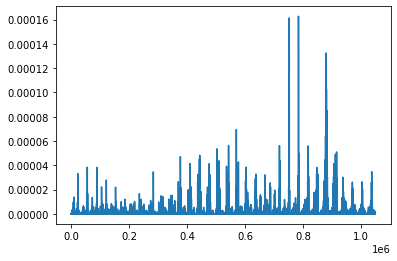

In [30]:
plt.plot( (c*x).ravel() )

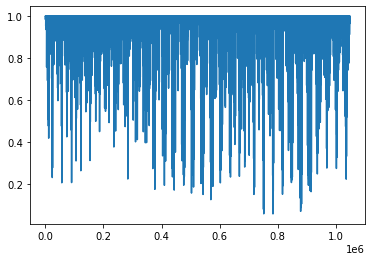

In [32]:
plt.plot( 10**-5 * (w).ravel() )

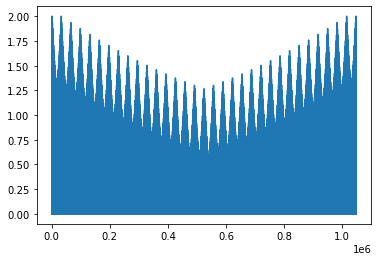

In [36]:
plt.plot( (c).ravel() )

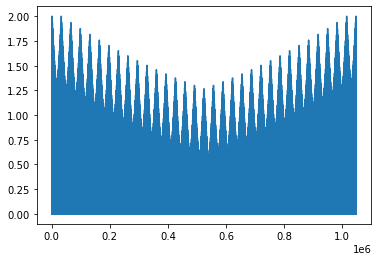

In [35]:
plt.plot( 10**-5 * (c*w).ravel() )

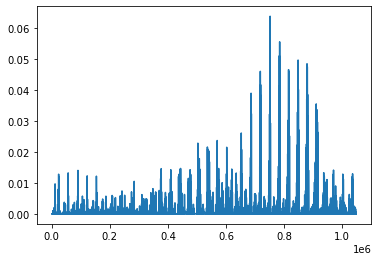

In [37]:
plt.plot( (c).ravel()- 10**-5 * (c*w).ravel() )

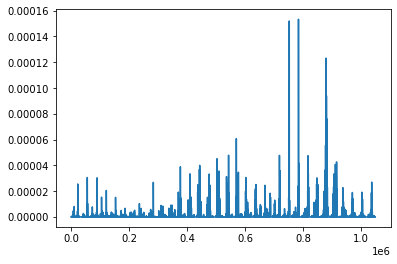

In [38]:
plt.plot( (c*x).ravel()- 10**-5 * (c*w*x).ravel() )

## Visualise and store results

In [ ]:
main_folder = folder + '_Results'
out_folder  = main_folder + '/' + instance
algorithm   = 'PD_Improved-'

In [ ]:
# Check if main folder for results exists, else create it
if not os.path.exists(main_folder):    os.makedirs(main_folder)
# Now create a folder for the results of the instance
if not os.path.exists(out_folder):    os.makedirs(out_folder)
out_folder += '/' + algorithm

### Spies & Heat maps

In [ ]:
# Visualise solution
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
plt.spy(x, markersize=1, aspect = 1, markeredgecolor = 'black', alpha=0.75);    plt.axis('off')
plt.title('Sparse view')
plt.subplot(1, 2, 2)
plt.imshow(x);    plt.axis('off');    plt.title('Heat map\n')

plt.savefig(out_folder+'Sparse-Heat.pdf', bbox_inches='tight',transparent=True)
plt.show()

Solution with initial guess:

In [ ]:
# Visualise solution
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
plt.spy(x, markersize=1, aspect = 1, markeredgecolor = 'black', alpha=0.75);    plt.axis('off')
plt.title('Sparse view')
plt.subplot(1, 2, 2)
plt.imshow(x);    plt.axis('off');    plt.title('Heat map\n')

#plt.savefig(out_folder+'Sparse-Heat.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [ ]:
# Visualise solution
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
plt.spy(x, markersize=1, aspect = 1, markeredgecolor = 'black', alpha=0.75);    plt.axis('off')
plt.title('Sparse view')
plt.subplot(1, 2, 2)
plt.imshow(x);    plt.axis('off');    plt.title('Heat map\n')

#plt.savefig(out_folder+'Sparse-Heat.pdf', bbox_inches='tight',transparent=True)
plt.show()

### Evolution across iterations

In [ ]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(obj)
plt.axhline(y=obj_exact, color='r', linestyle=':')
plt.yscale('log');    plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(np.append([0], every_iter['time']),obj)
plt.axhline(y=obj_exact, color='r', linestyle=':')
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [ ]:
# Visualise evolution of relative errors
plt.figure(figsize = (20,11))

plt.subplot(2, 2, 1)
plt.plot(every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 2)
plt.plot(every_iter['time'],every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 3)
plt.plot(every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in solution (log scale)')
plt.subplot(2, 2, 4)
plt.plot(every_iter['time'],every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in solution (log scale)')

#plt.savefig(out_folder+'Rel_Error.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [ ]:
# Relative variation
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates per iteration')

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates against time')

#plt.savefig(out_folder+'Relative_Var.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [ ]:
# Relative variation for x𝟙 = m
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')

#plt.savefig(out_folder+'RelE_m.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [ ]:
# Relative variation for 𝟙ᵀx = n
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

#plt.savefig(out_folder+'RelE_n.pdf', bbox_inches='tight',transparent=True)
plt.show()

### Export as dataframes

All the data from the above two plots is also available as dataframes:

In [ ]:
df_critical = pd.DataFrame.from_dict(every_critical)
df_critical.to_pickle(out_folder+'Critical.pkl') # To read back use pd.read_pickle(file_name)
df_critical.to_excel(out_folder+'Critical.xlsx')
display(df_critical)

# If we want this table in LaTeX format run:
print(df_critical.to_latex(index=False))

In [ ]:
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['hyperₘ', 'hyperₙ'] } ),
                pd.DataFrame.from_dict( {'hyperₘ-'+a:b for a,b in every_iter['hyperₘ'].items()} ), 
                pd.DataFrame.from_dict( {'hyperₙ-'+a:b for a,b in every_iter['hyperₙ'].items()} )], axis = 1)
df_every.to_pickle(out_folder+'Every.pkl') # To read back use pd.read_pickle(file_name)
df_every.to_excel(out_folder+'Every.xlsx')
display(df_every.head())

In [ ]:
df_every.describe()

In [ ]:
# Finally, store the latest solution:
np.save(out_folder + '_Sol.npy' , x)            # To read back just run:   np.load(outfile)

---
Code used to do performance tests in each piece of code:
```Python
start = time.time()
# ...
end = time.time()
print(end-start)

%timeit -r 10 -n 200 `function(x)`
```

Not much of a speedup for interpolation:
```Python
@jit(nopython=True, fastmath = True)
def interp(xₖ,x, yₖ,y, ρ):
    return ρ*xₖ + (1 - ρ)*x, ρ*yₖ + (1 - ρ)*y

xₖ, yₖ, x, y = ones((4,M,N)); ρ = 1.9
interp(xₖ,x, yₖ,y, ρ); # Run it once
```

---